In [1]:
import torch
import paths
import itertools
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix

In [2]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [3]:
model = torch.load(paths.MODEL_PATH, map_location=device)


In [4]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
    transforms.Resize(224),                       # Resize to fit ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for ResNet
])

In [5]:
class CustomImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        # Call the parent class's __getitem__ to retrieve image and label
        original_tuple = super(CustomImageFolder, self).__getitem__(index)
        # Retrieve the path from self.imgs, which stores tuples of (path, class_index)
        path, _ = self.imgs[index]
        # Return a tuple with the filename, image, and label
        # Ensure path is a string, as expected by Path
        return (Path(path).name, *original_tuple)
    
# Load the dataset
test_dataset = CustomImageFolder(root=paths.TEST_DIR, transform=transform)

# Dataloader
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
# Testing the model
all_labels = []
all_preds = []
all_probs = []
all_ids = []
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for image_ids, images, labels in tqdm(test_loader, desc='Generating predictions'):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probabilities.cpu().numpy())
        all_ids.extend(image_ids)
        

    print(f'Accuracy of the model on test images: {100 * correct / total}%')


Generating predictions:   0%|          | 0/16 [00:00<?, ?it/s]

Accuracy of the model on test images: 97.69076305220884%


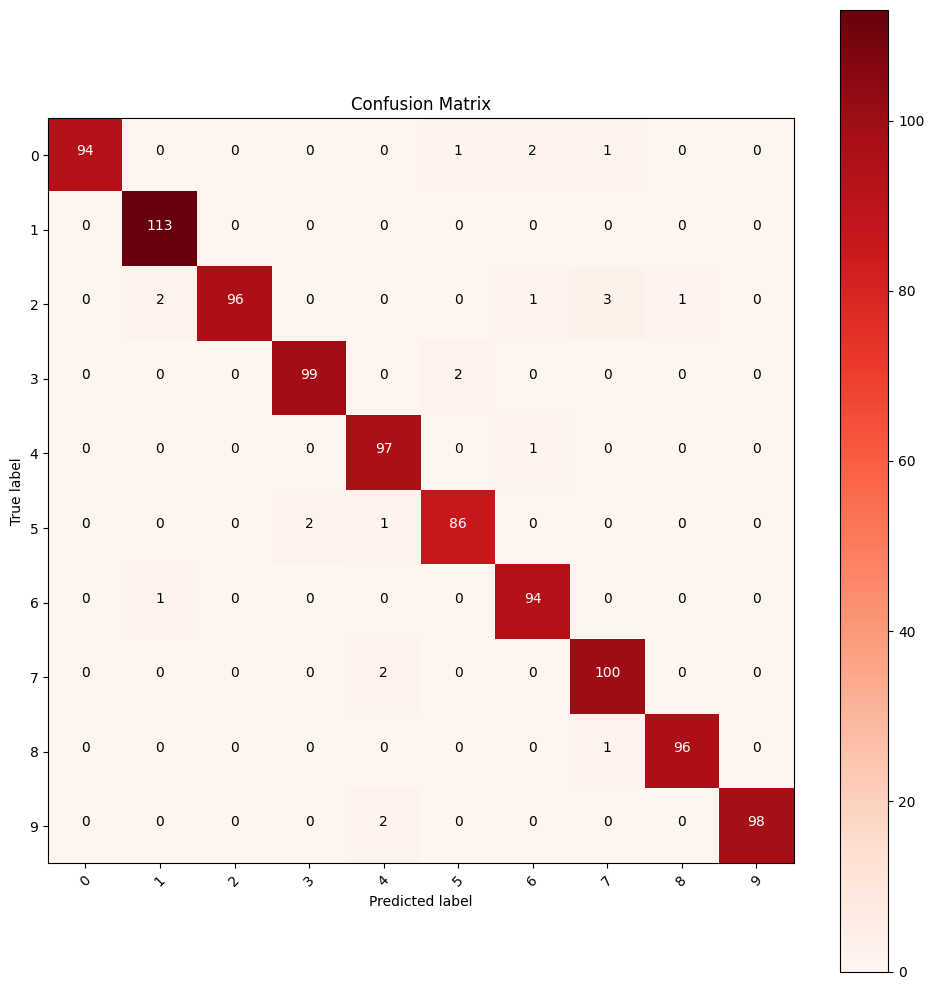

In [7]:
# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Optionally: Plot the confusion matrix using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_loader.dataset.classes))
plt.xticks(tick_marks, test_loader.dataset.classes, rotation=45)
plt.yticks(tick_marks, test_loader.dataset.classes)

# Labeling the plot
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [8]:
all_probs = np.array(all_probs)

In [9]:
all_probs.shape

(996, 10)

In [10]:
predictions_df = pd.DataFrame(all_probs, columns=test_loader.dataset.classes)
predictions_df.head()

,0,1,2,3,4,5,6,7,8,9
0,0.999809,6.798254e-07,1.335217e-05,6.384101e-08,2.533161e-07,2.963368e-07,5.312761e-05,1.252649e-07,1.213906e-04,1.953124e-06
1,0.997537,6.221592e-07,1.807104e-03,7.323354e-06,5.416872e-06,4.987413e-05,1.102487e-05,3.017257e-05,4.329317e-04,1.188915e-04
2,0.999991,2.289948e-07,1.003262e-07,3.547471e-09,1.086462e-07,2.707716e-08,5.171905e-06,5.111453e-07,2.277950e-06,7.796183e-07
3,0.999975,2.259185e-08,2.139078e-06,4.857823e-09,3.414337e-08,2.617793e-08,1.369709e-05,1.777881e-08,8.291740e-06,6.427915e-07
4,0.999999,1.280876e-08,1.133607e-09,2.218342e-10,5.184680e-09,1.791631e-09,8.153793e-07,4.176838e-08,1.630816e-07,8.210721e-08


In [11]:
predictions_df.insert(0, 'id', all_ids)
predictions_df['prediction'] = all_labels
predictions_df.head()

,id,0,1,2,3,4,5,6,7,8,9,prediction
0,1009.jpg,0.999809,6.798254e-07,1.335217e-05,6.384101e-08,2.533161e-07,2.963368e-07,5.312761e-05,1.252649e-07,1.213906e-04,1.953124e-06,0
1,1047.jpg,0.997537,6.221592e-07,1.807104e-03,7.323354e-06,5.416872e-06,4.987413e-05,1.102487e-05,3.017257e-05,4.329317e-04,1.188915e-04,0
2,1188.jpg,0.999991,2.289948e-07,1.003262e-07,3.547471e-09,1.086462e-07,2.707716e-08,5.171905e-06,5.111453e-07,2.277950e-06,7.796183e-07,0
3,1271.jpg,0.999975,2.259185e-08,2.139078e-06,4.857823e-09,3.414337e-08,2.617793e-08,1.369709e-05,1.777881e-08,8.291740e-06,6.427915e-07,0
4,1590.jpg,0.999999,1.280876e-08,1.133607e-09,2.218342e-10,5.184680e-09,1.791631e-09,8.153793e-07,4.176838e-08,1.630816e-07,8.210721e-08,0


In [12]:
predictions_df.to_csv(paths.PREDICTIONS_PATH, index=False, float_format="%.6f")